<IPython.core.display.Javascript object>


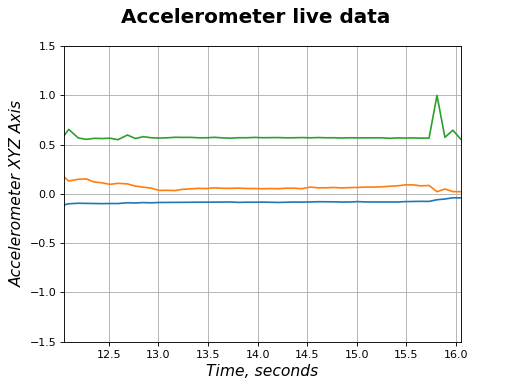

<IPython.core.display.Javascript object>


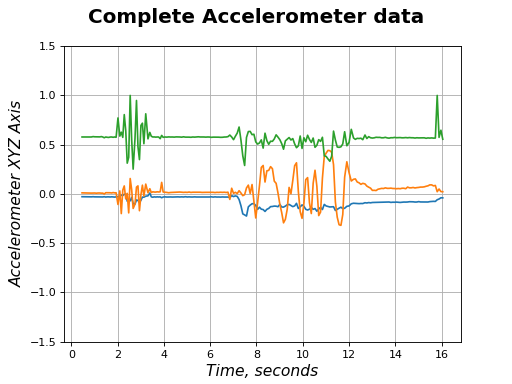

Button(description='Accelerometer Demo', style=ButtonStyle())

Button(description='Smoke Sensor Demo', style=ButtonStyle())

Button(description='Temperature Demo', style=ButtonStyle())

Button(description='Adc Gpio Demo', style=ButtonStyle())

In [1]:
%matplotlib notebook

import serial
import numpy as np
from matplotlib import pyplot as plt
from time import time
from ipywidgets import widgets
from IPython.display import clear_output



# Please change here to proper COM port name
##########################################################################################
comport = 'COM5'

# Duration of the demo / length of the raw data graph
##########################################################################################
time_raw = 4         # seconds of data to view at once
time_complete = 16   # total seconds to collect data



##################################################################################################
# Accelerometer sensor demo
##################################################################################################
def ADXL362_write_reg(reg, value, serialport):
    cmd = "<0a%0.2x%0.2x>" % (reg, value) # Write command 0x0A
    serialport.write(bytearray(cmd,'utf8'))  # Send command, REG and value
    return

def ADXL362_read_reg8(reg, serialport):
    serialport.reset_input_buffer()
    cmd = "<0b%0.2x..>" % reg # Read command 0x0B
    serialport.write(bytearray(cmd,'utf8'))  # Send command, REG and value
    s = ser.read(2)
    return int(s,16)                  # Convert hex to int
#
def ADXL362_read_reg16(reg, serialport):
    serialport.reset_input_buffer()
    cmd = "<0b%0.2x..><0b%0.2x..>" % (reg+1, reg) # Read command 0x0B
    serialport.write(bytearray(cmd,'utf8'))  # Send command, REG and value
    s = serialport.read(4)
    return int(s,16)                 # Convert hex to int
#
# Read sign extended 16 bit register 
#
def ADXL362_read_reg16_sx(reg, serialport):
    t = ADXL362_read_reg16(reg, serialport)
    if t > 32768: t = t - 65536
    return t    

def ADXL362_read_axis(axis, serialport):
    return ADXL362_read_reg16_sx(axis*2 + 0x0e, serialport)

def run_accelerometer_demo(comport, time_raw, time_complete):

    ser = serial.Serial(comport, 115200)
    #
    # ADXL362 register access functions
    #
    ser.write(b'[0]')                      # Select UHSA Channel 0 
    #
    # We need enable measurements!
    #
    ADXL362_write_reg(0x2d, 0x02, ser)     # Enable Measurement Mode     
    ADXL362_read_axis(0, ser)              # Some dummy read first..

    #
    # Plot functions start here
    #
    plt.ion() 
    start_time = time()
    timepoints = []
    xdata = []
    ydata = []
    zdata = []

    yrange = [-1.5,1.5]

    fig1 = plt.figure()
    fig1.suptitle('Accelerometer live data', fontsize='18', fontweight='bold')
    plt.axes().grid(True)
    plt.xlabel('Time, seconds', fontsize='14', fontstyle='italic')
    plt.ylabel('Accelerometer XYZ Axis', fontsize='14', fontstyle='italic')

    line1, = plt.plot(xdata)
    line2, = plt.plot(ydata)
    line3, = plt.plot(zdata)

    plt.ylim(yrange)
    plt.xlim([0,time_raw])

    ser.flushInput()                      # Flush junk
    ser.reset_input_buffer()

    run = True

    # collect the data and plot a moving frame
    while run:
        # 
        try:
            x = ADXL362_read_axis(0, ser)    
            y = ADXL362_read_axis(1, ser)    
            z = ADXL362_read_axis(2, ser)    

            # store the entire dataset for later
            xdata.append(float(x)*2.0/4096)
            ydata.append(float(y)*2.0/4096)
            zdata.append(float(z)*2.0/4096)

            timepoints.append(time()-start_time)
            current_time = timepoints[-1]

            # update the plotted data
            line1.set_xdata(timepoints)
            line1.set_ydata(xdata)

            line2.set_xdata(timepoints)
            line2.set_ydata(ydata)

            line3.set_xdata(timepoints)
            line3.set_ydata(zdata)

            # slide the viewing frame along
            if current_time > time_raw:
                plt.xlim([current_time-time_raw, current_time])

            # when time's up, kill the collect+plot loop
            if timepoints[-1] > time_complete: run=False

        # if the try statement throws an error, just do nothing
        except: pass

        # update the plot
        fig1.canvas.draw()

    # plot all of the data you collected
    fig2 = plt.figure()
    fig2.suptitle('Complete Accelerometer data', fontsize='18', fontweight='bold')
    plt.axes().grid(True)
    plt.xlabel('Time, seconds', fontsize='14', fontstyle='italic')
    plt.ylabel('Accelerometer XYZ Axis', fontsize='14', fontstyle='italic')

    plt.plot(timepoints, xdata, timepoints, ydata, timepoints, zdata)
    plt.ylim(yrange)
    fig2.show()

    ser.close()

    return



##################################################################################################
# Smoke sensor demo
##################################################################################################
#
# ADPD register access functions
#
def ADPD_write_reg(reg, value, serialport):
    serialport.reset_input_buffer() #
    cmd = "<c8K%0.2xK%0.2xK%0.2xK>" % (reg, (value >> 8), (value & 0xFF))
    serialport.write(bytearray(cmd,'utf8'))  # Send command, REG and value
    return

def ADPD_read_reg(reg, serialport):
    serialport.reset_input_buffer() #
    cmd = "<c8K%0.2xK<c9K..m..M>" % reg  # 
    serialport.write(bytearray(cmd,'utf8'))  # Send command, REG and value
    s = serialport.read(4)
    return int(s, 16)

def ADPD_read_fifo(serialport):
    fifolevel = ADPD_read_reg(0x00, serialport) >> 8
    # Do something if fifo level < 2 ?
    retval = ADPD_read_reg(0x60, serialport)
    retval = 1.0 * retval/16384
    return retval
#
# ADPD register init from ADI Wavetool Application
# Filename: ADPD188BI_SK.dcfg
#
def ADPD_init_SK(serialport):
    ADPD_write_reg(0x00 ,0x1000, serialport)
    ADPD_write_reg(0x01 ,0xC0FF, serialport)
    ADPD_write_reg(0x02 ,0x0005, serialport)
    ADPD_write_reg(0x06 ,0x0F00, serialport)
    ADPD_write_reg(0x09 ,0x00C8, serialport)
    ADPD_write_reg(0x10 ,0x0000, serialport)
    ADPD_write_reg(0x11 ,0x30A9, serialport)
    ADPD_write_reg(0x12 ,0x0050, serialport)
    ADPD_write_reg(0x14 ,0x0117, serialport)
    ADPD_write_reg(0x15 ,0x0220, serialport)
    ADPD_write_reg(0x18 ,0x1F00, serialport)
    ADPD_write_reg(0x19 ,0x3FFF, serialport)
    ADPD_write_reg(0x1A ,0x3FFF, serialport)
    ADPD_write_reg(0x1B ,0x3FFF, serialport)
    ADPD_write_reg(0x1E ,0x1F00, serialport)
    ADPD_write_reg(0x1F ,0x3FFF, serialport)
    ADPD_write_reg(0x20 ,0x3FFF, serialport)
    ADPD_write_reg(0x21 ,0x3FFF, serialport)
    ADPD_write_reg(0x22 ,0x3531, serialport)
    ADPD_write_reg(0x23 ,0x3533, serialport)
    ADPD_write_reg(0x24 ,0x3531, serialport)
    ADPD_write_reg(0x25 ,0x6317, serialport)
    ADPD_write_reg(0x30 ,0x0319, serialport)
    ADPD_write_reg(0x31 ,0x0810, serialport)
    ADPD_write_reg(0x34 ,0x0000, serialport)
    ADPD_write_reg(0x35 ,0x0319, serialport)
    ADPD_write_reg(0x36 ,0x0810, serialport)
    ADPD_write_reg(0x38 ,0x0000, serialport)
    ADPD_write_reg(0x39 ,0x2203, serialport)
    ADPD_write_reg(0x3B ,0x2203, serialport)
    ADPD_write_reg(0x3C ,0x31C6, serialport)
    ADPD_write_reg(0x3E ,0x0320, serialport)
    ADPD_write_reg(0x3F ,0x0320, serialport)
    ADPD_write_reg(0x42 ,0x1C34, serialport)
    ADPD_write_reg(0x43 ,0xADA5, serialport)
    ADPD_write_reg(0x44 ,0x1C34, serialport)
    ADPD_write_reg(0x45 ,0xADA5, serialport)
    ADPD_write_reg(0x4B ,0x269C, serialport)
    ADPD_write_reg(0x4D ,0x0082, serialport)
    ADPD_write_reg(0x54 ,0x0AA0, serialport)
    ADPD_write_reg(0x58 ,0x0000, serialport)
    ADPD_write_reg(0x59 ,0x0808, serialport)
    ADPD_write_reg(0x5A ,0x0010, serialport)
    ADPD_write_reg(0x5E ,0x0808, serialport)
    ADPD_write_reg(0x5F ,0x0000, serialport)
    return
    
def ADPD_init(serialport):
    ADPD_init_SK(serialport)
    # Change one setting
    ADPD_write_reg(0x11 ,0x3065, serialport)  # Channel A,B, Average, 16 bit sum of channels
    # Enter normal mode
    ADPD_write_reg(0x10 ,0x0002, serialport)
    return

def run_smoke_sensor_demo(comport, time_raw, time_complete):
    
    ser = serial.Serial(comport, 115200)      # open serilaport
    ser.flushInput()
    ser.reset_input_buffer()
    ser.write(b'[6]')                         # Select UHSA I2C Channel
    ser.reset_input_buffer()
    #
    # Check sensor ID
    #
    id = ADPD_read_reg(0x08, ser)
    print("Smoke Sensor ID:", hex(id))
    #
    # "Normal" Register Init
    # 
    ADPD_init(ser)

    print("FIFO samples", ADPD_read_reg(0x00, ser) >> 8)
    print("FIFO data", hex(ADPD_read_reg(0x60, ser)))

    #
    # Plot Sensor FIFO read data
    #
    plt.ion() 
    start_time = time()
    timepoints = []
    xdata = []
    ydata = []
    zdata = []

    yrange = [-0.75,5.1]

    fig1 = plt.figure()
    fig1.suptitle('Smoke Sensor live data', fontsize='18', fontweight='bold')
    plt.axes().grid(True)
    plt.xlabel('Time, seconds', fontsize='14', fontstyle='italic')
    plt.ylabel('Sensor reading', fontsize='14', fontstyle='italic')

    line1, = plt.plot(xdata)
    line2, = plt.plot(ydata)
    line3, = plt.plot(zdata)

    plt.ylim(yrange)
    plt.xlim([0,time_raw])

    ser.flushInput() # Flush junk

    run = True

    # collect the data and plot a moving frame
    while run:
        
        try:
            x = ADPD_read_fifo(ser)
            # store the entire dataset for later
            xdata.append(x)

            y = ADPD_read_fifo(ser)
            # store the entire dataset for later
            ydata.append(y)

            z = x/y
            zdata.append(z)

            timepoints.append(time()-start_time)
            current_time = timepoints[-1]

            # update the plotted data
            line1.set_xdata(timepoints)
            line1.set_ydata(xdata)

            line2.set_xdata(timepoints)
            line2.set_ydata(ydata)

            line3.set_xdata(timepoints)
            line3.set_ydata(zdata)        

            # slide the viewing frame along
            if current_time > time_raw:
                plt.xlim([current_time-time_raw,current_time])

            # when time's up, kill the collect+plot loop
            if timepoints[-1] > time_complete: run=False

        # if the try statement throws an error, just do nothing
        except: pass

        # update the plot
        fig1.canvas.draw()

    # plot all of the data you collected
    fig2 = plt.figure()
    fig2.suptitle('Complete Smoke Sensor  data', fontsize='18', fontweight='bold')
    plt.axes().grid(True)
    plt.xlabel('Time, seconds', fontsize='14', fontstyle='italic')
    plt.ylabel('Sensor Reading', fontsize='14', fontstyle='italic')

    plt.plot(timepoints, xdata)
    plt.plot(timepoints, ydata)
    plt.plot(timepoints, zdata)
    plt.ylim(yrange)
    fig2.show()
    #
    # Blue LED will go off, also the GPIO0 LED
    #
    ADPD_write_reg(0x0F ,0x0001, ser) # Issue Softreset
    
    ser.close()
    
    return



##################################################################################################
# Temperature Sensor demo
##################################################################################################
#
# ADT7320 register access functions
#
def ADT7320_read_reg8(reg, serialport):
    serialport.reset_input_buffer()
    cmd = "<%0.2x..>" % (reg*8 + 64) 
    serialport.write(bytearray(cmd,'utf8'))   # Send read register command
    s = serialport.read(2)                    # Read data byte
    return int(s,16)                          # return unsigned 8 bit int

def ADT7320_read_reg16(reg, serialport):
    serialport.reset_input_buffer()
    cmd = "<%0.2x....>" % (reg*8 + 64)
    serialport.write(bytearray(cmd,'utf8'))   # Send read register command
    s = serialport.read(4)                    # Read two data bytes
    x = int(s,16)                             # Convert hex to int
    if x > 32768: x = x - 65536               # Convert to signed int
    return x    

def run_temperature_demo(comport, time_raw, time_complete):

    ser = serial.Serial(comport, 115200)
    ser.flushInput()
    ser.reset_input_buffer()
    ser.write(b'[1]')                         # Select UHSA ADT Channel

    print('ADT7320 ID Register:', hex(ADT7320_read_reg8(3, ser)))
    print("Tcrit Setpoint     :", ADT7320_read_reg16(4, ser)/128, "C")
    print("Thigh Setpoint     :", ADT7320_read_reg16(6, ser)/128, "C")
    print("Tlow Setpoint      :", ADT7320_read_reg16(7, ser)/128, "C")
    print("Thyst Setpoint     :", ADT7320_read_reg8(5, ser), "C")
    print("")
    print("Temperature:",ADT7320_read_reg16(2, ser)/128, "C")

    plt.ion() 
    start_time = time()
    timepoints = []
    ydata = []
    yrange = [25.0,45.0]

    fig1 = plt.figure()
    fig1.suptitle('Temperature live data', fontsize='18', fontweight='bold')
    plt.axes().grid(True)
    plt.xlabel('Time, seconds', fontsize='14', fontstyle='italic')
    plt.ylabel('Temperature, degrees Celsius', fontsize='14', fontstyle='italic')
    line1, = plt.plot(ydata)
    plt.ylim(yrange)
    plt.xlim([0,time_raw])

    ser.flushInput()                          # Flush junk

    run = True

    # collect the data and plot a moving frame
    while run:

        try:
            y = ADT7320_read_reg16(2, ser)/128

            # store the entire dataset for later
            ydata.append(y)

            timepoints.append(time()-start_time)
            current_time = timepoints[-1]

            # update the plotted data
            line1.set_xdata(timepoints)
            line1.set_ydata(ydata)

            # slide the viewing frame along
            if current_time > time_raw:
                plt.xlim([current_time-time_raw,current_time])

            # when time's up, kill the collect+plot loop
            if timepoints[-1] > time_complete: run=False

        # if the try statement throws an error, just do nothing
        except: pass

        # update the plot
        fig1.canvas.draw()

    # plot all of the data you collected
    fig2 = plt.figure()
    fig2.suptitle('Complete temperature data', fontsize='18', fontweight='bold')
    plt.axes().grid(True)
    plt.xlabel('Time, seconds', fontsize='14', fontstyle='italic')
    plt.ylabel('Temperature, degrees Celsius', fontsize='14', fontstyle='italic')

    plt.plot(timepoints, ydata)
    plt.ylim(yrange)
    fig2.show()

    ser.close()

    return



##################################################################################################
# AnalogMax: AD5592R ADC/DAC/GPIO Demo
##################################################################################################
#
# AD5592 register access functions
#
ADC_GAIN = 1 # Default Gain is 1 after reset/poweron

def AD5592_write_reg(reg, value, serialport):
    cmd = "<%0.4x>" % ((reg << 11) + (value & 0xfff))
    serialport.write(bytearray(cmd,'utf8'))  # Send command, REG and value
    return

def AD5592_write_dac(dac, value, serialport):
    cmd = "<%0.4x>" % ((dac << 12) + (value & 0xfff) | 0x8000)
    serialport.write(bytearray(cmd,'utf8'))  # Send command, REG and value
    return

def AD5592_read16(serialport):
    serialport.reset_input_buffer()
    serialport.write(b'<....>')   # Read result, (scan-in NOP)
    s = serialport.read(4)        # Read two data bytes
    return int(s,16)       # Convert hex to int
#
# Temperature(C) = 25 + (ADC - 820/Gain)/2.654
#
def AD5592_get_temperature(serialport):
    # Get result, assume that temp channel is enabled!
    t = AD5592_read16(serialport) & 0xfff # Strip Channel bits
    t = 25 + (t - 820/ADC_GAIN)/2.654
    return round(t,2)    
#
def AD5592_get_adc(serialport):
    # Get result, assume that single ADC channel is enabled!
    t = ADC_GAIN*2.5*(AD5592_read16(serialport) & 0xfff)/4096      # Strip Channel bits
    return round(t,2) 


def run_adc_dac_gpio_demo(comport, time_raw, time_complete):

    ser = serial.Serial(comport, 115200)
    ser.flushInput()
    ser.reset_input_buffer()

    ser.write(b'[2]')                            # Select UHSA AD5592 Channel
    #
    # Issue Software Reset first
    # 
    AD5592_write_reg(0xf, 0xdac, ser)     # Soft Reset MAGIC

    # General-Purpose Control 
    AD5592_write_reg(3, 0x30, ser)        # ADC and DAC range VREF*2
    ADC_GAIN = 2                                 # Change gain for calculations  
    #
    # Configure ADC for repeated Temperature Readings
    #

    # Power Down/Ref control: enable intref
    AD5592_write_reg(0x0b, 0x200, ser)
    # ADC SEQUENCE: REP, Temperature
    AD5592_write_reg(0x2, 0x300, ser)

    print("Temperature is: ", AD5592_get_temperature(ser), "C")

    AD5592_write_reg(0x2, 0, ser)         # ADC SEQUENCE: none

    #
    # DAC7
    #
    AD5592_write_reg(0x5, 0x80, ser)      # IO7 to DAC
    AD5592_write_dac(7, 2048, ser)        # DAC7 mid-scale = 2.5V
    AD5592_write_reg(0x1, 0x18 | 7, ser)  # DAC7 readback
    print("DAC7 Set to mid-scale, readback is:", AD5592_read16(ser) & 0xfff)  # NOTE: disable ADC sequence!
    #
    # GPIO
    #
    AD5592_write_reg(0x6, 0x00, ser)      # pulldown mode set to OFF
    AD5592_write_reg(0x8, 0x7c, ser)      # IO2..6 as GPIO Output
    AD5592_write_reg(0x9, 0xff, ser)      # GPIO Output register to all 1's
    print("IO[2..6] Set as output high")

    AD5592_write_reg(0x7, 0x60, ser)      # Readback GPIO Write Config
    x = AD5592_read16(ser)
    print("GPIO Write Config Register readback:", "0x%0.2X" % (x & 0xff))  # NOTE: disable ADC sequence!

    # GPIO input
    AD5592_write_reg(0xa,         0x02, ser)   # GPIO Read Config, IO1 is input
    AD5592_write_reg(0xa, 0x400 | 0x02, ser)   # GPIO Read Config, IO1 is input, enable readback
    x = AD5592_read16(ser)
    print("GPIO read state:", "0x%0.2X" % (x & 0xff)) # NOTE: disable ADC sequence!
    #
    # ADC0
    #
    AD5592_write_reg(4, 0x01, ser)             # ADC Config: enable IO0
    AD5592_write_reg(2, 0x01 | 0x200, ser)     # ADC SEQUENCE: ADC0, Repeat

    print("ADC0 result is:", AD5592_get_adc(ser), "V")
    #
    # Plot ADC0
    #
    plt.ion() 
    start_time = time()
    timepoints = []
    ydata = []

    yrange = [-0.75,5.1]
    time_raw = time_raw / 2              # 4 seconds of data to view at once
    time_complete = time_complete / 2   # 8 seconds of total collected data

    fig1 = plt.figure()
    fig1.suptitle('ADC AIN0 live data', fontsize='18', fontweight='bold')
    plt.axes().grid(True)
    plt.xlabel('Time, seconds', fontsize='14', fontstyle='italic')
    plt.ylabel('AIN0, volts', fontsize='14', fontstyle='italic')
    line1, = plt.plot(ydata)
    plt.ylim(yrange)
    plt.xlim([0,time_raw])

    ser.flushInput()    # Flush junk

    run = True

    # collect the data and plot a moving frame
    while run:
        
        try:
            y = AD5592_get_adc(ser)

            # store the entire dataset for later
            ydata.append(y)

            timepoints.append(time()-start_time)
            current_time = timepoints[-1]

            # update the plotted data
            line1.set_xdata(timepoints)
            line1.set_ydata(ydata)

            # slide the viewing frame along
            if current_time > time_raw:
                plt.xlim([current_time-time_raw,current_time])

            # when time's up, kill the collect+plot loop
            if timepoints[-1] > time_complete: run=False

        # if the try statement throws an error, just do nothing
        except: pass

        # update the plot
        fig1.canvas.draw()

    # plot all of the data you collected
    fig2 = plt.figure()
    fig2.suptitle('Complete ADC data', fontsize='18', fontweight='bold')
    plt.axes().grid(True)
    plt.xlabel('Time, seconds', fontsize='14', fontstyle='italic')
    plt.ylabel('AIN0, volts', fontsize='14', fontstyle='italic')
    plt.plot(timepoints, ydata)
    plt.ylim(yrange)
    fig2.show()

    ser.close()
    
    return



##################################################################################################
# Buttons
##################################################################################################
button1 = widgets.Button(description="Accelerometer Demo")
display(button1)

def on_button_clicked(b):
    clear_output()
    run_accelerometer_demo(comport, time_raw, time_complete)
    display(button1)
    display(button2)
    display(button3)
    display(button4)
    
button1.on_click(on_button_clicked)


button2 = widgets.Button(description="Smoke Sensor Demo")
display(button2)

def on_button_clicked(b):
    clear_output()
    run_smoke_sensor_demo(comport, time_raw, time_complete)
    display(button1)
    display(button2)
    display(button3)
    display(button4)
    
button2.on_click(on_button_clicked)


button3 = widgets.Button(description="Temperature Demo")
display(button3)

def on_button_clicked(b):
    clear_output()
    run_temperature_demo(comport, time_raw, time_complete)
    display(button1)
    display(button2)
    display(button3)
    display(button4)
    
button3.on_click(on_button_clicked)


button4 = widgets.Button(description="Adc Gpio Demo")
display(button4)

def on_button_clicked(b):
    clear_output()
    run_adc_dac_gpio_demo(comport, time_raw, time_complete)
    display(button1)
    display(button2)
    display(button3)
    display(button4)
    
button4.on_click(on_button_clicked)
